In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
from IPython.core.display import display, HTML
np.random.seed(42)

%matplotlib inline

In [2]:
beauty_df = pd.read_csv("./ARM_Data_extra/examples/beauty/ProfEvaltnsBeautyPublic.csv")

In [23]:
beauty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 64 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tenured            463 non-null    int64  
 1   profnumber         463 non-null    int64  
 2   minority           463 non-null    int64  
 3   age                463 non-null    int64  
 4   beautyf2upper      463 non-null    int64  
 5   beautyflowerdiv    463 non-null    int64  
 6   beautyfupperdiv    463 non-null    int64  
 7   beautym2upper      463 non-null    int64  
 8   beautymlowerdiv    463 non-null    int64  
 9   beautymupperdiv    463 non-null    int64  
 10  btystdave          463 non-null    float64
 11  btystdf2u          463 non-null    float64
 12  btystdfl           463 non-null    float64
 13  btystdfu           463 non-null    float64
 14  btystdm2u          463 non-null    float64
 15  btystdml           463 non-null    float64
 16  btystdmu           463 non

In [18]:
with pd.option_context("display.max_rows", 70, "display.max_columns", 10):
    display(HTML(beauty_df.describe().T.to_html()))

,count,mean,std,min,25%,50%,75%,max
tenured,463.0,0.546436,0.498377,0.000000,0.000000,1.000000,1.000000,1.000000
profnumber,463.0,45.434125,27.508902,1.000000,20.000000,44.000000,70.500000,94.000000
minority,463.0,0.138229,0.345513,0.000000,0.000000,0.000000,0.000000,1.000000
age,463.0,48.365011,9.802742,29.000000,42.000000,48.000000,57.000000,73.000000
beautyf2upper,463.0,5.213823,2.018224,1.000000,4.000000,5.000000,6.000000,10.000000
beautyflowerdiv,463.0,3.963283,1.873936,1.000000,2.000000,4.000000,5.000000,8.000000
beautyfupperdiv,463.0,5.019438,1.934437,1.000000,4.000000,5.000000,7.000000,9.000000
beautym2upper,463.0,4.751620,1.575266,1.000000,4.000000,5.000000,6.000000,9.000000
beautymlowerdiv,463.0,3.412527,1.637102,1.000000,2.000000,3.000000,5.000000,7.000000
beautymupperdiv,463.0,4.146868,2.110586,1.000000,3.000000,4.000000,5.000000,9.000000


We clearly have too many columns to even bother with a pairplot and further analysis. Let's try our intuition and take some we consider most meaningful.

In [26]:
beauty_df_mdl1 = beauty_df[[
    'courseevaluation',
    'tenured',
    'tenuretrack',
    'minority',
    'age',
    'didevaluation',
    'female',
    'formal',
    'fulldept',
    'nonenglish',
    'students',
    'blkandwhite'
]]

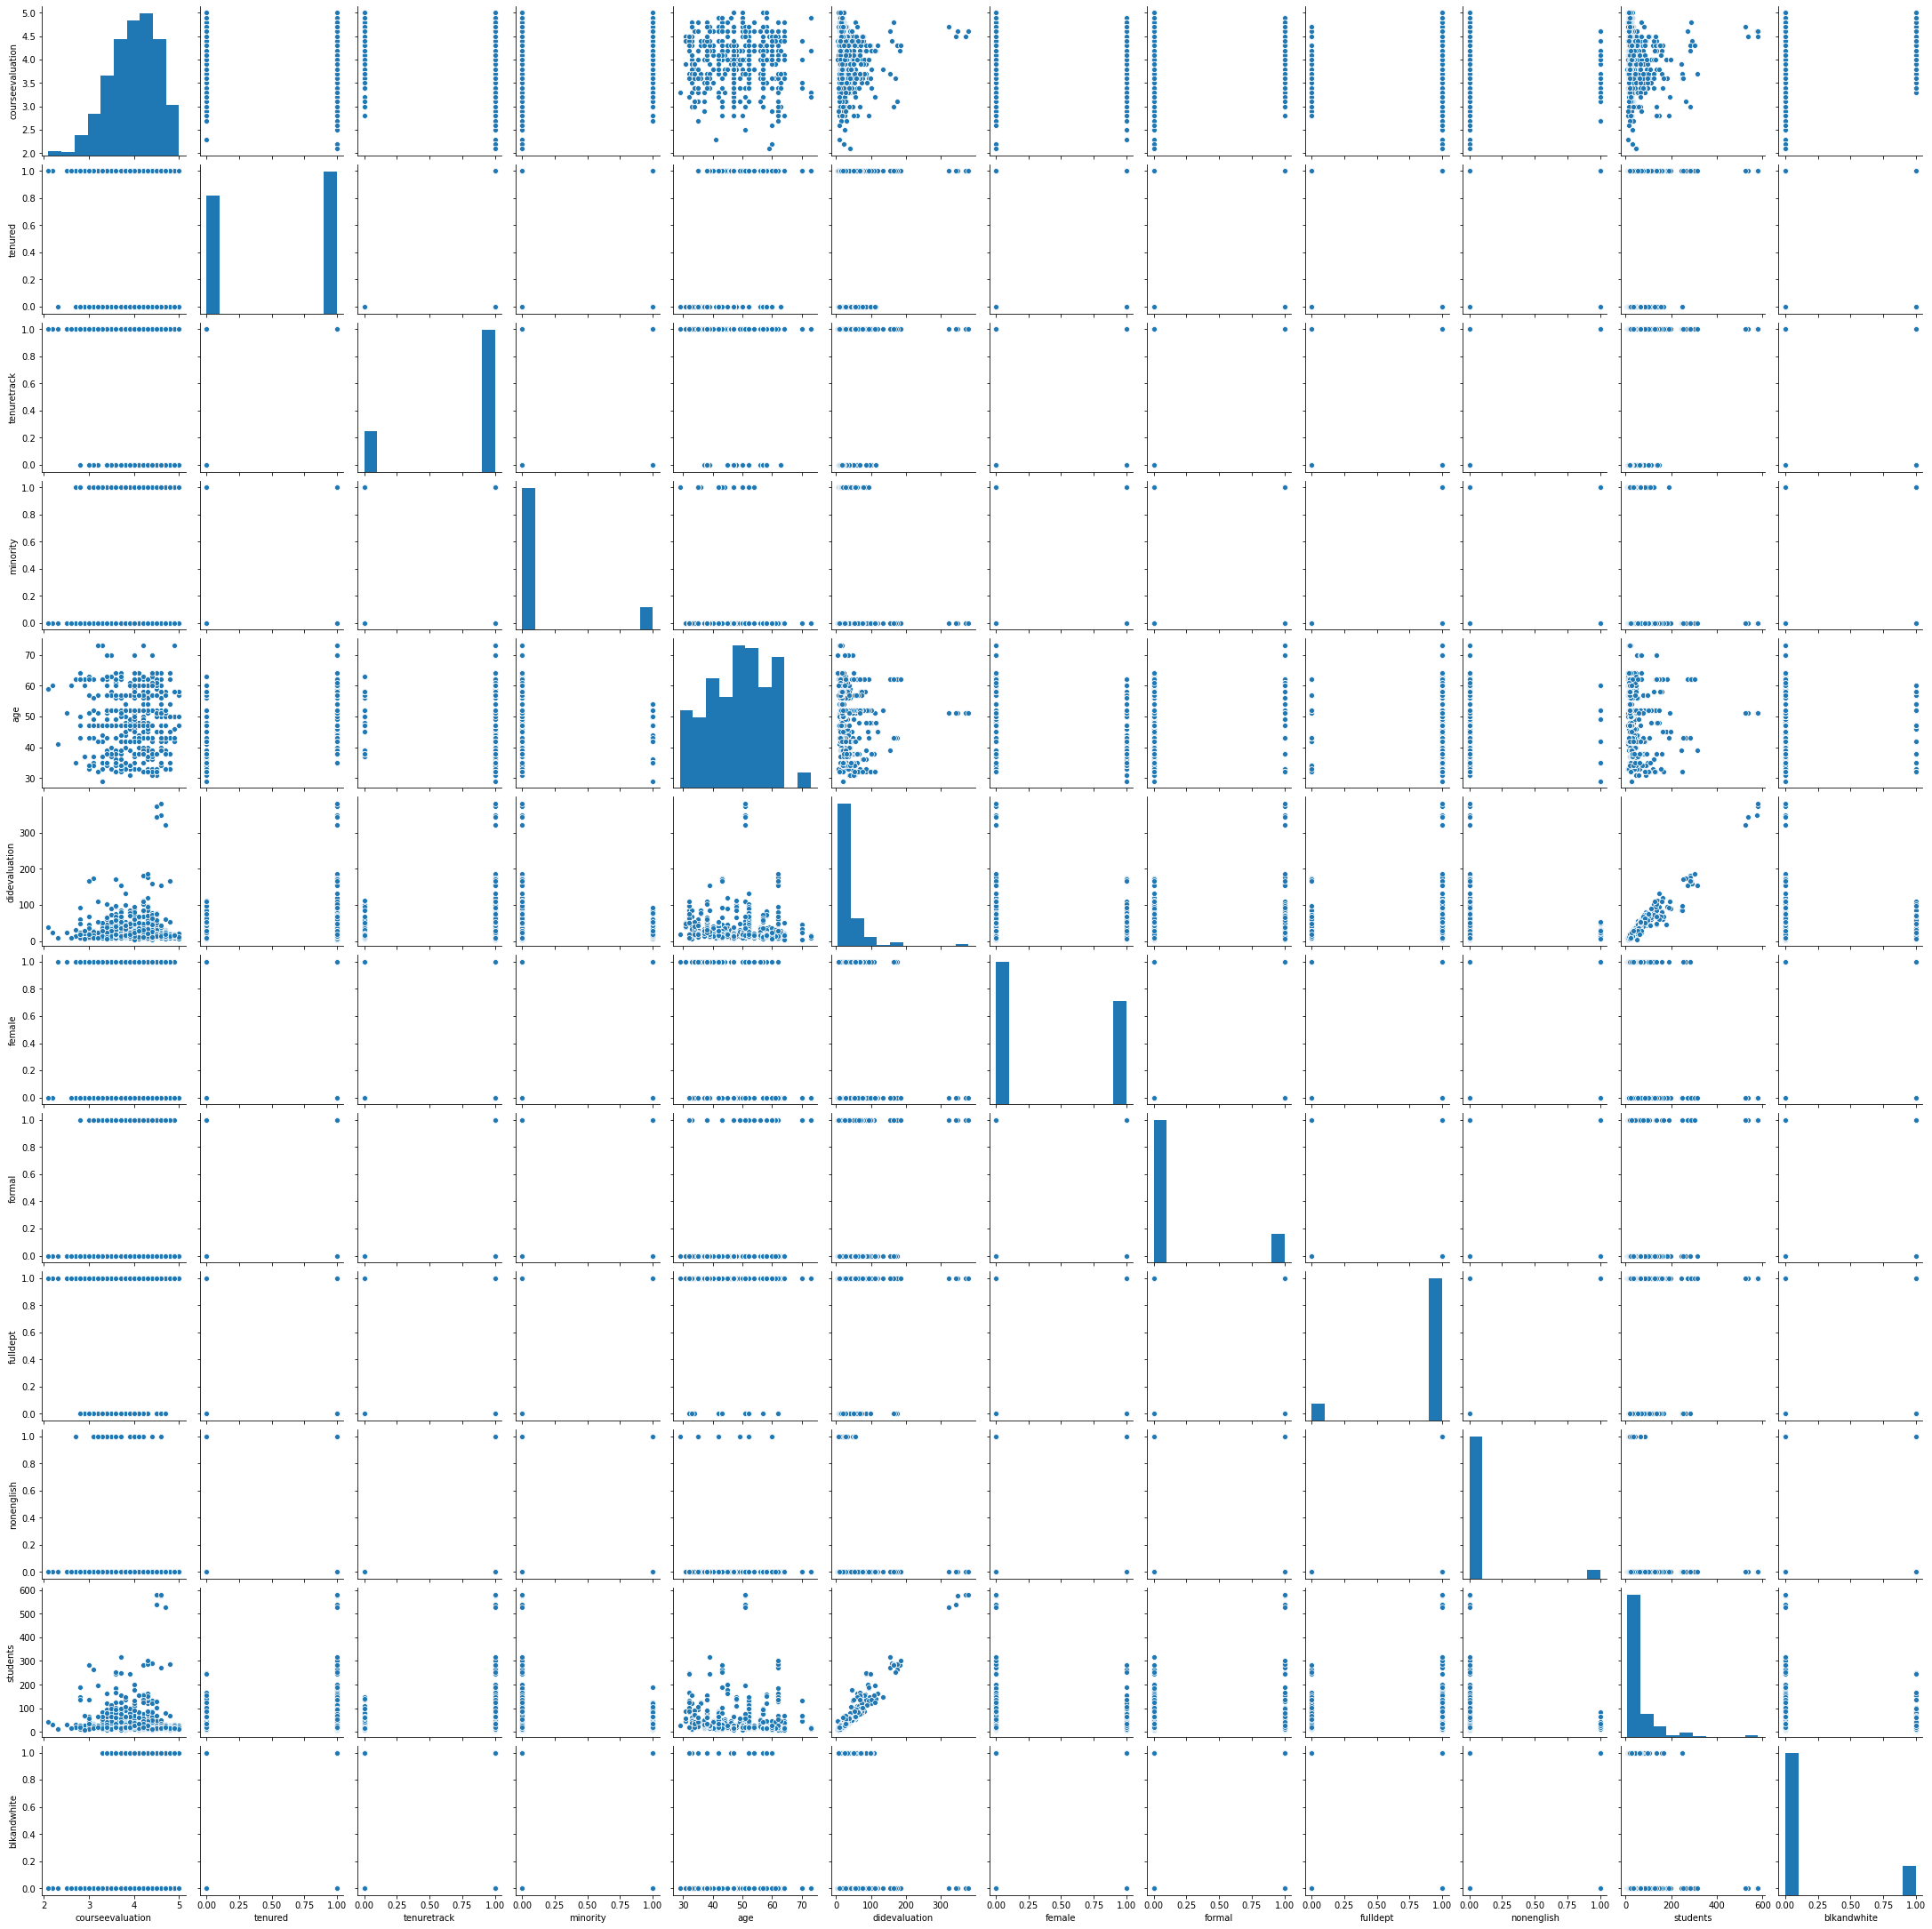

In [27]:
sns.pairplot(beauty_df_mdl1)

* Target variable is semi-normally distributed, which is good, no transformation feels necessary.
* many of the binary variables have some correlation with the target variable, we can expect those to contribute to the model quality.
* age is suspicious, will try to fit it as-is, but some bucketing might help.
* didevaluation and students seem very long-tailed, log-transformation might be useful. I'm not sure how didevaluation matches a non-binary value here, some clarification is needed.

In [28]:
beauty_df_mdl1 = beauty_df_mdl1.assign(
    didevaluation=lambda x: np.log(x.didevaluation),
    students=lambda x: np.log(x.students),
)

In [29]:
beauty_df_mdl1.describe().T

,count,mean,std,min,25%,50%,75%,max
courseevaluation,463.0,3.998272,0.554866,2.100000,3.600000,4.000000,4.400000,5.000000
tenured,463.0,0.546436,0.498377,0.000000,0.000000,1.000000,1.000000,1.000000
tenuretrack,463.0,0.779698,0.414899,0.000000,1.000000,1.000000,1.000000,1.000000
minority,463.0,0.138229,0.345513,0.000000,0.000000,0.000000,0.000000,1.000000
age,463.0,48.365011,9.802742,29.000000,42.000000,48.000000,57.000000,73.000000
didevaluation,463.0,3.239825,0.770910,1.609438,2.708050,3.135494,3.688879,5.940171
female,463.0,0.421166,0.494280,0.000000,0.000000,0.000000,1.000000,1.000000
formal,463.0,0.166307,0.372758,0.000000,0.000000,0.000000,0.000000,1.000000
fulldept,463.0,0.894168,0.307955,0.000000,1.000000,1.000000,1.000000,1.000000
nonenglish,463.0,0.060475,0.238623,0.000000,0.000000,0.000000,0.000000,1.000000


In [30]:
mdl1 = sm.OLS(
    exog=sm.add_constant(beauty_df_mdl1.drop(columns=['courseevaluation'])),
    endog=beauty_df_mdl1.courseevaluation
).fit()
mdl1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       courseevaluation   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     9.249
Date:                Sun, 08 Mar 2020   Prob (F-statistic):           5.07e-15
Time:                        12:12:29   Log-Likelihood:                -336.66
No. Observations:                 463   AIC:                             697.3
Df Residuals:                     451   BIC:                             747.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.6468      0.231     20.111      0.000       4.193       5.101
tenured           0.0024      0.074      0.032      0.974      -0.144       0.149
tenuretrack      -0.2064      0.082     -2.502      0.013      -0.368      -0.044
minority         -0.0440      0.075     -0.589      0.556      -0.191       0.103
age              -0.0087      0.003     -2.779      0.006      -0.015      -0.003
didevaluation     0.2982      0.103      2.906      0.004       0.097       0.500
female           -0.2360      0.052     -4.497      0.000      -0.339      -0.133
formal            0.1761      0.071      2.496      0.013       0.037       0.315
fulldept          0.2296      0.083      2.768      0.006       0.067       0.393
nonenglish       -0.4117      0.111     -3.722      0.000      -0.629      -0.194
students         -0.3315      0.095     -3.501      0.001      -0.518      -0.145
blkandwhite       0.2703      0.067      4.060      0.000       0.139       0.401
==============================================================================
Omnibus:                       20.727   Durbin-Watson:                   1.542
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.282
Skew:                          -0.526   Prob(JB):                     1.45e-05
Kurtosis:                       3.219   Cond. No.                         506.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

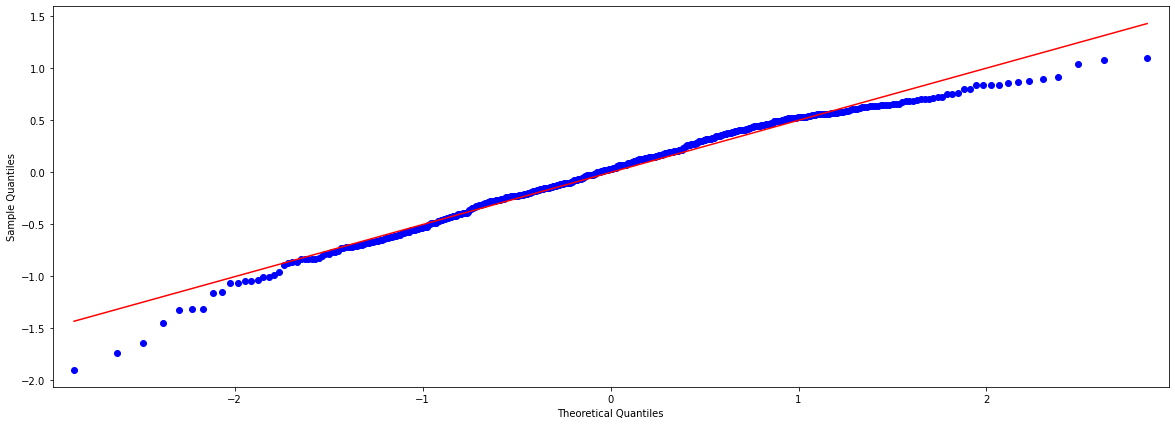

In [31]:
with plt.rc_context():
    plt.rc("figure", figsize=(20,7))
    sm.qqplot(mdl1.resid, line='r');

In [59]:
smr = mdl1.get_prediction(sm.add_constant(beauty_df_mdl1.drop(columns=['courseevaluation']))).summary_frame(alpha=1)

In [60]:
smr

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,3.776463,0.086540,3.776463,3.776463,3.776463,3.776463
1,4.008799,0.051027,4.008799,4.008799,4.008799,4.008799
2,4.093508,0.057810,4.093508,4.093508,4.093508,4.093508
3,3.917908,0.063137,3.917908,3.917908,3.917908,3.917908
4,3.994575,0.066077,3.994575,3.994575,3.994575,3.994575
...,...,...,...,...,...,...
458,4.036450,0.096015,4.036450,4.036450,4.036450,4.036450
459,4.092191,0.071801,4.092191,4.092191,4.092191,4.092191
460,3.395865,0.116270,3.395865,3.395865,3.395865,3.395865
461,3.412106,0.116807,3.412106,3.412106,3.412106,3.412106


In [35]:
olsinf = mdl1.get_influence()

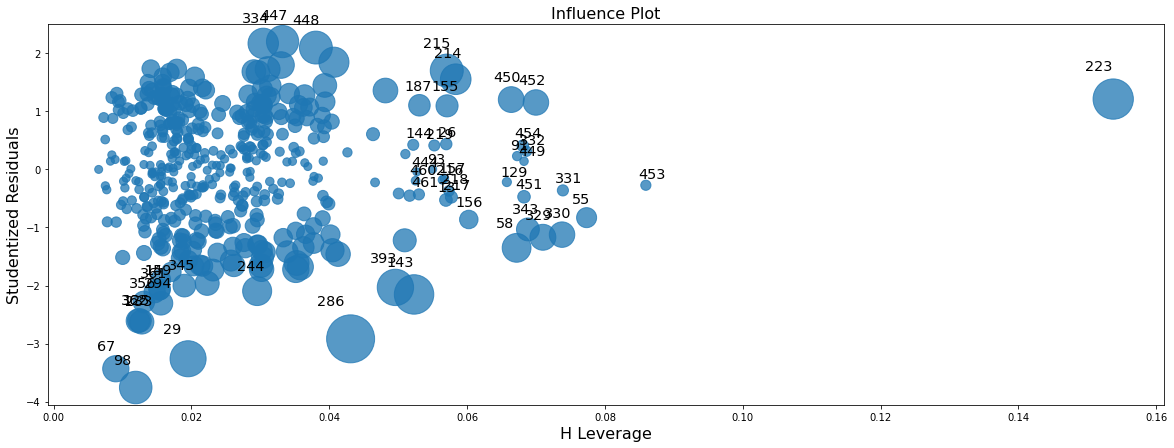

In [38]:
with plt.rc_context():
    plt.rc("figure", figsize=(20,7))
    olsinf.plot_influence();

In [50]:
from statsmodels.stats.outliers_influence import summary_table

smr1 = summary_table(mdl1)

In [51]:
olsinf.summary_frame()

,dfb_const,dfb_tenured,dfb_tenuretrack,dfb_minority,dfb_age,dfb_didevaluation,dfb_female,dfb_formal,dfb_fulldept,dfb_nonenglish,dfb_students,dfb_blkandwhite,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.018454,-0.050608,0.049891,0.116217,-0.010086,-0.071315,0.033917,-0.005104,0.037641,-0.059326,0.074857,-0.003400,0.002740,1.047395,0.029102,0.181338,1.047508,0.181358
1,-0.014157,0.000163,0.030439,-0.019882,0.041013,0.027542,-0.018247,-0.028681,0.002577,-0.003457,-0.035473,-0.023141,0.000807,0.973233,0.010118,0.098396,0.973176,0.098390
2,0.013967,-0.011556,-0.009985,0.015037,-0.011295,-0.060939,0.022153,0.025589,0.003063,-0.005106,0.052452,0.013686,0.000668,-0.780803,0.012987,-0.089563,-0.780465,-0.089525
3,0.012886,0.051595,-0.015966,-0.024061,-0.035247,0.019772,0.050889,-0.013608,0.018456,0.011413,-0.018613,-0.026958,0.000756,0.759115,0.015491,0.095221,0.758758,0.095177
4,-0.002223,-0.040804,0.043958,-0.034854,-0.018686,0.023618,0.032403,-0.005405,0.025869,-0.008359,-0.019647,-0.026202,0.000935,0.806076,0.016967,0.105899,0.805763,0.105858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,-0.111905,0.081627,-0.078267,0.042610,0.124035,0.221033,0.092377,0.000446,-0.085880,0.041859,-0.187429,0.020516,0.008731,-1.679235,0.035824,-0.323683,-1.682641,-0.324340
459,0.001909,-0.027518,0.022167,-0.010024,-0.015559,-0.009808,-0.024269,-0.007004,0.013688,-0.006282,0.015133,-0.002075,0.000292,0.413816,0.020034,0.059167,0.413436,0.059113
460,0.012175,0.006434,-0.005618,-0.009675,-0.006023,-0.004893,-0.008766,0.012748,-0.001735,-0.032627,0.000142,0.004797,0.000174,-0.194146,0.052534,-0.045716,-0.193939,-0.045667
461,0.027116,0.014544,-0.012755,-0.021140,-0.014104,-0.015374,-0.019123,0.028080,-0.002605,-0.072349,0.004745,0.010946,0.000861,-0.429667,0.053019,-0.101667,-0.429278,-0.101575
